In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns

In [2]:
DATA_DIR = "./data"

In [57]:
train_df = pd.read_csv(f"{DATA_DIR}/train.csv")
test_df = pd.read_csv(f"{DATA_DIR}/test.csv")

train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [58]:
len(train_df), len(test_df)

(891, 418)

In [59]:
cabin_dict = { cabin_id: index for index, cabin_id in enumerate(pd.concat((train_df["Cabin"], test_df["Cabin"])).unique()) }
embarked_dict = { embarked: index for index, embarked in enumerate(pd.concat((train_df["Embarked"], test_df["Embarked"])).unique()) }

In [60]:
def preprocess(df: pd.DataFrame):
    df["Age"] = df["Age"].fillna(-1.0)
    df["Fare"] = df["Fare"].fillna(0.0)
    
    df["fare_normalized"] = df["Fare"] / df["Fare"].max()
    df["age_normalized"] = df["Age"] / 100.0

    bins = [-2.0, 0.0, 15.0, 35.0, 55.0, 100.0]
    df["age_group"] = pd.cut(df["Age"], bins=bins, labels=list(range(len(bins)-1))).astype(float)
    
    df["maritial_status"] = df["Name"].apply(lambda name: any([x in name.lower() for x in ["mrs", "mr"]])).astype(float)
    df["sex_encoded"] = df["Sex"].apply(lambda x: x == "male").astype(float)

    df["embarked_encoded"] = df["Embarked"].apply(lambda x: embarked_dict[x])

    df["relatives"] = (df["Parch"] + df["SibSp"]) > 0
    df["relatives"] = df["relatives"].astype(float)

    df["cabin_encoded"] = df["Cabin"].apply(lambda x: cabin_dict[x]).astype(float)

    return df

In [61]:
train_df = preprocess(train_df)
test_df = preprocess(test_df)

In [62]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_normalized,age_normalized,age_group,maritial_status,sex_encoded,embarked_encoded,relatives,cabin_encoded
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,0.014151,0.22,2.0,1.0,1.0,0,1.0,0.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,0.139136,0.38,3.0,1.0,0.0,1,1.0,1.0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0.015469,0.26,2.0,0.0,0.0,0,0.0,0.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,0.103644,0.35,2.0,1.0,0.0,0,1.0,2.0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,0.015713,0.35,2.0,1.0,1.0,0,0.0,0.0


In [63]:
correlation_matrix = train_df[["Survived", "Pclass", "sex_encoded", "maritial_status", "age_normalized", "age_group", "fare_normalized", "relatives", "cabin_encoded"]].corr()
correlation_matrix

,Survived,Pclass,sex_encoded,maritial_status,age_normalized,age_group,fare_normalized,relatives,cabin_encoded
Survived,1.000000,-0.338481,-0.543351,-0.332993,0.012439,0.023124,0.257307,0.203367,0.270495
Pclass,-0.338481,1.000000,0.131900,0.028038,-0.359728,-0.325745,-0.549500,-0.135207,-0.623554
sex_encoded,-0.543351,0.131900,1.000000,0.521630,0.023365,0.007568,-0.182333,-0.303646,-0.082104
maritial_status,-0.332993,0.028038,0.521630,1.000000,0.213930,0.153953,-0.120227,-0.154593,-0.013333
age_normalized,0.012439,-0.359728,0.023365,0.213930,1.000000,0.951758,0.135707,-0.027030,0.234568
age_group,0.023124,-0.325745,0.007568,0.153953,0.951758,1.000000,0.134733,0.019716,0.222086
fare_normalized,0.257307,-0.549500,-0.182333,-0.120227,0.135707,0.134733,1.000000,0.271832,0.397105
relatives,0.203367,-0.135207,-0.303646,-0.154593,-0.027030,0.019716,0.271832,1.000000,0.097066
cabin_encoded,0.270495,-0.623554,-0.082104,-0.013333,0.234568,0.222086,0.397105,0.097066,1.000000


<Axes: >

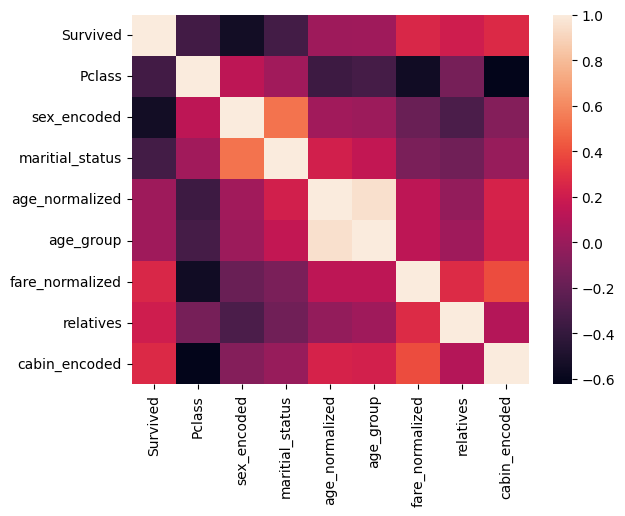

In [64]:
sns.heatmap(correlation_matrix)

<Axes: xlabel='Sex'>

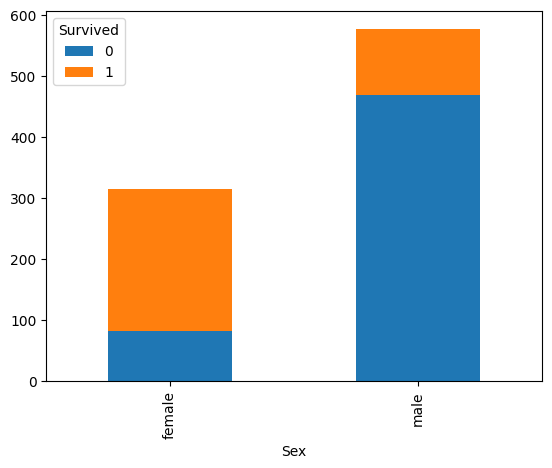

In [65]:
train_df.groupby(["Sex", "Survived"])["Sex"].count().unstack("Survived").plot.bar(stacked=True)

<Axes: xlabel='Pclass'>

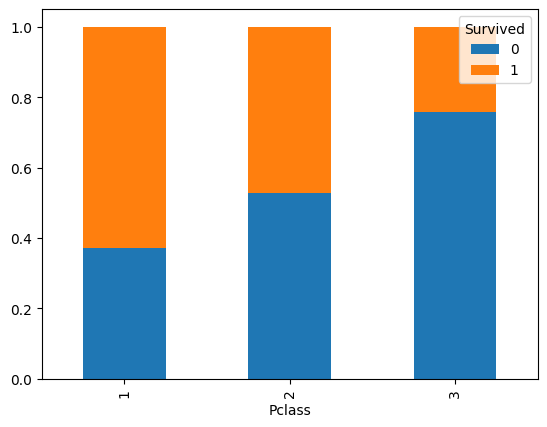

In [66]:
pclass_group = train_df.groupby(["Pclass", "Survived"])["Pclass"].count().unstack("Survived")
pclass_group = pclass_group.div(pclass_group.sum(axis=1), axis=0)
pclass_group.plot.bar(stacked=True)

<Axes: xlabel='age_group'>

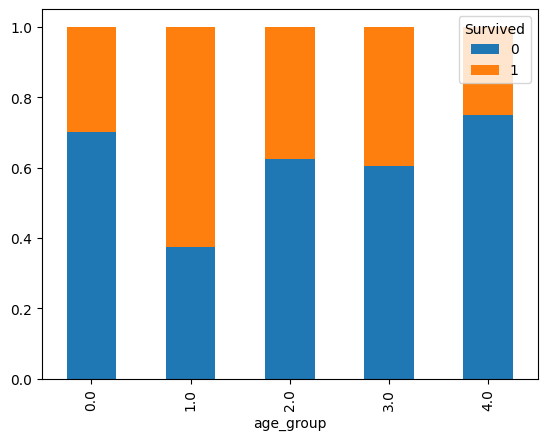

In [97]:
age_group_group = train_df.groupby(["age_group", "Survived"])["age_group"].count().unstack("Survived")
age_group_group = age_group_group.div(age_group_group.sum(axis=1), axis=0)
age_group_group.plot.bar(stacked=True)

<Axes: xlabel='SibSp'>

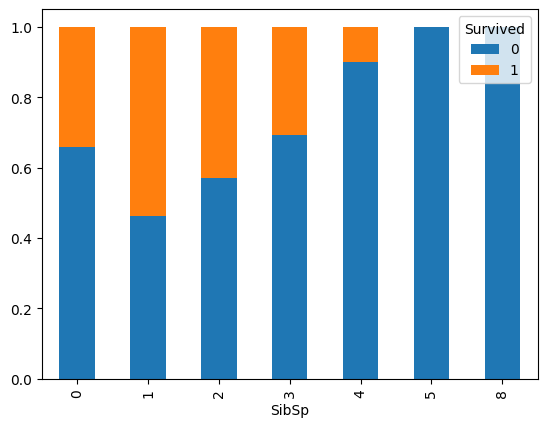

In [99]:
sibsp_survived = train_df.groupby(["SibSp", "Survived"])["SibSp"].count().unstack("Survived")
sibsp_survived = sibsp_survived.div(sibsp_survived.sum(axis=1), axis=0)
sibsp_survived.plot.bar(stacked=True)

<Axes: xlabel='Parch'>

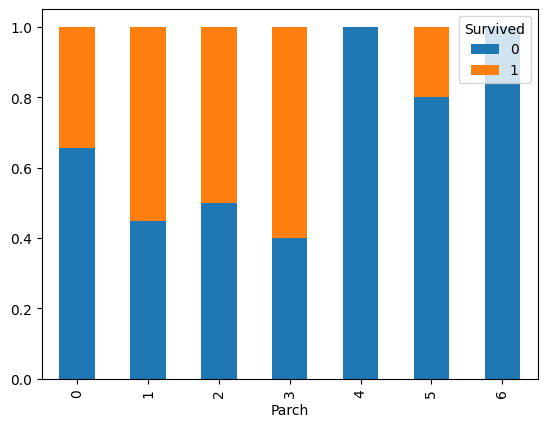

In [69]:
parch_survived = train_df.groupby(["Parch", "Survived"])["Parch"].count().unstack("Survived")
parch_survived = parch_survived.div(parch_survived.sum(axis=1), axis=0)
parch_survived.plot.bar(stacked=True)

<Axes: xlabel='Embarked'>

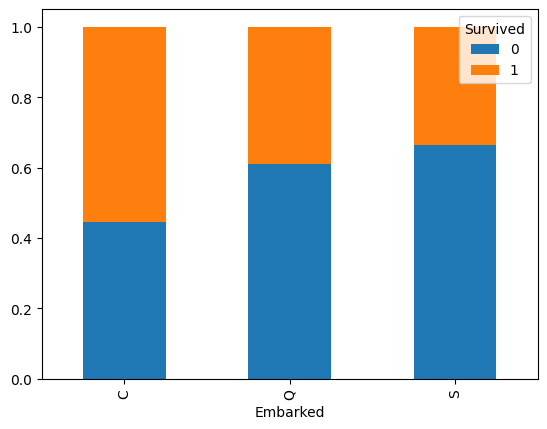

In [70]:
embarked_survived = train_df.groupby(["Embarked", "Survived"])["Embarked"].count().unstack("Survived")
embarked_survived = embarked_survived.div(embarked_survived.sum(axis=1), axis=0)
embarked_survived.plot.bar(stacked=True)

<Axes: xlabel='maritial_status'>

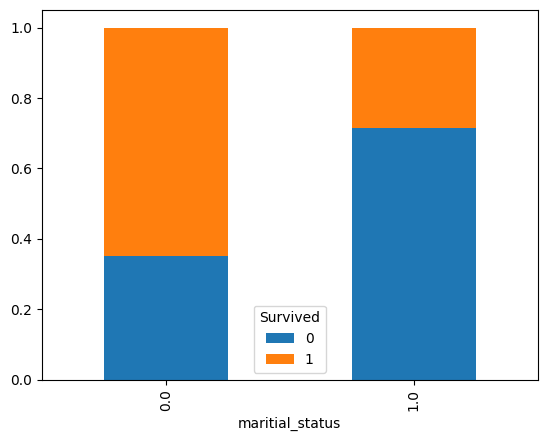

In [71]:
embarked_survived = train_df.groupby(["maritial_status", "Survived"])["maritial_status"].count().unstack("Survived")
embarked_survived = embarked_survived.div(embarked_survived.sum(axis=1), axis=0)
embarked_survived.plot.bar(stacked=True)

In [72]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df[["Survived", "Sex"]])

In [73]:
len(test_df[test_df["Age"].isna()]), len(test_df[test_df["Pclass"].isna()]), len(test_df[test_df["Sex"].isna()]), len(test_df[test_df["Fare"].isna()]), len(test_df[test_df["Embarked"].isna()]), len(test_df[test_df["Name"].isna()])

(0, 0, 0, 0, 0, 0)

In [74]:
class TitanicDataset(torch.utils.data.Dataset):
    def __init__(self, df: pd.DataFrame, cols: list[str]):
        super(TitanicDataset, self).__init__()
        self.data = torch.tensor(df[cols].values, dtype=torch.float32)
        self.labels = torch.tensor(df["Survived"].values, dtype=torch.float32)

    def __getitem__(self, index):
        return self.data[index], self.labels[index]

    def __len__(self):
        return len(self.labels)

In [191]:
cols = ["sex_encoded", "Pclass", "age_normalized", "age_group", "fare_normalized", "SibSp", "Parch", "embarked_encoded", "maritial_status"]
# cols = ["sex_encoded", "Pclass", "age_normalized", "maritial_status", "cabin_encoded"]

train_ds = TitanicDataset(df=train_df, cols=cols)
val_ds = TitanicDataset(df=val_df, cols=cols)

In [192]:
BATCH_SIZE = 4

train_dataloader = torch.utils.data.DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=True)

In [193]:
class TitanicModel(nn.Module):
    def __init__(self, input_size: int):
        super(TitanicModel, self).__init__()
        self.sequence = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=128),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=128, out_features=64),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=64, out_features=32),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(in_features=32, out_features=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.sequence(x)

model = TitanicModel(input_size=len(cols))
criterion = nn.BCELoss()

In [194]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 300

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

for epoch in range(EPOCHS):
    running_loss = []
    train_acc = []

    val_loss = []
    val_acc = []

    model.train()
    for i, data in enumerate(train_dataloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())
        outputs[outputs > 0.5] = 1.0
        outputs[outputs <= 0.5] = 0.0
        train_acc.append(np.sum(np.array(outputs == labels)) / len(labels))

    
    model.eval()
    for i, data in enumerate(val_dataloader, 0):
        outputs = model(inputs).squeeze(1)
        loss = criterion(outputs, labels)

        val_loss.append(loss.item())
        outputs[outputs > 0.5] = 1.0
        outputs[outputs <= 0.5] = 0.0
        val_acc.append(np.sum(np.array(outputs == labels)) / len(labels))

    print(f'Epoch {epoch} - Train loss: {np.mean(running_loss):.4f}, Train accuracy: {np.mean(train_acc)}, Val loss: {np.mean(val_loss)}, Val accuracy: {np.mean(val_acc)}')

print('Finished Training')

Epoch 0 - Train loss: 0.6542, Train accuracy: 0.6165730337078652, Val loss: 0.6062300801277161, Val accuracy: 0.75
Epoch 1 - Train loss: 0.5950, Train accuracy: 0.6910112359550562, Val loss: 0.4106895327568054, Val accuracy: 1.0
Epoch 2 - Train loss: 0.5648, Train accuracy: 0.7275280898876404, Val loss: 0.7055128216743469, Val accuracy: 0.5
Epoch 3 - Train loss: 0.5367, Train accuracy: 0.7584269662921348, Val loss: 0.6982980370521545, Val accuracy: 0.5
Epoch 4 - Train loss: 0.5339, Train accuracy: 0.7724719101123596, Val loss: 0.3610553443431854, Val accuracy: 0.75
Epoch 5 - Train loss: 0.5198, Train accuracy: 0.773876404494382, Val loss: 0.34538525342941284, Val accuracy: 0.75
Epoch 6 - Train loss: 0.4931, Train accuracy: 0.776685393258427, Val loss: 0.48563122749328613, Val accuracy: 0.5
Epoch 7 - Train loss: 0.4972, Train accuracy: 0.7907303370786517, Val loss: 0.8665761947631836, Val accuracy: 0.5
Epoch 8 - Train loss: 0.4939, Train accuracy: 0.7851123595505618, Val loss: 0.7802321

In [195]:
from sklearn.ensemble import RandomForestClassifier

In [196]:
X = train_df[cols].values
y = train_df["Survived"].values
val_X = val_df[cols].values
val_y = val_df["Survived"].values

In [210]:
random_forest = RandomForestClassifier(n_estimators=100, random_state=10)
random_forest.fit(X, y)

RandomForestClassifier(random_state=10)

In [211]:
val_pred = random_forest.predict(val_X)
val_pred[val_pred > 0.5] = 1.0
val_pred[val_pred <= 0.5] = 0.0
np.sum(np.array(val_pred == val_y)) / len(val_y)

0.8156424581005587

## Test submission

In [212]:
test_df["Survived"] = -1

In [213]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,fare_normalized,age_normalized,age_group,maritial_status,sex_encoded,embarked_encoded,relatives,cabin_encoded,Survived
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0.015282,0.345,2.0,1.0,1.0,2,0.0,0.0,-1
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,0.013663,0.470,3.0,1.0,0.0,0,1.0,0.0,-1
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0.018909,0.620,4.0,1.0,1.0,2,0.0,0.0,-1
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0.016908,0.270,2.0,1.0,1.0,0,0.0,0.0,-1
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,0.023984,0.220,2.0,1.0,0.0,0,1.0,0.0,-1


In [214]:
test_ds = TitanicDataset(df=test_df, cols=cols)

In [202]:
test_dataloader = torch.utils.data.DataLoader(test_ds, batch_size=1, shuffle=False)

In [203]:
model.eval()

predictions = []

for data in test_dataloader:
    inputs, labels = data
    output = model(inputs)
    predictions.append(output.item())

predictions = np.array(predictions)

predictions[predictions > 0.5] = 1
predictions[predictions <= 0.5] = 0

In [215]:
predictions = random_forest.predict(test_df[cols].values)

In [216]:
submission_df = pd.DataFrame(test_df["PassengerId"])
submission_df["Survived"] = predictions.astype(np.int64)
submission_df.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [217]:
submission_df.to_csv("./submission.csv", index=False)